# Predicting the Bachmannpreis

### Goals
* Find the best parameters for Random Forest model to predict winning authors
* Make persistent model with joblib
* Visualize model performance

### Import libraries

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

from joblib import dump, load
from smac.tae import StatusType

import autosklearn.classification

In [2]:
!pip install matplotlib

### Read in the data

In [3]:
df = pd.read_csv('prediction_table.csv')

X_train = df[df.year < 2020].drop(columns=['price_won'])
X_test = df[df.year == 2020].drop(columns=['price_won'])
y_train = df[df.year < 2020][["price_won"]]
y_test = df[df.year == 2020][["price_won"]]

### Auto-Sklearn models

In [4]:
cls = autosklearn.classification.AutoSklearnClassifier(
    include_estimators=["random_forest",],
    exclude_estimators=None,
    include_preprocessors=["no_preprocessing",],
    exclude_preprocessors=None,
    time_left_for_this_task=120,
    per_run_time_limit=30,
)

cls.fit(X_train, y_train, X_test, y_test)

predictions = cls.predict(X_test)

In [5]:
print(cls.sprint_statistics())
print("Accuracy score:{}".format(
    sklearn.metrics.accuracy_score(y_test, predictions))
)

auto-sklearn results:
  Dataset name: 21504f07ac62159131d7042bd1804a0c
  Metric: accuracy
  Best validation score: 0.843750
  Number of target algorithm runs: 56
  Number of successful target algorithm runs: 55
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0

Accuracy score:0.8571428571428571


### Save the model

In [ ]:
dump(cls, 'bachmann_automl.joblib') 

In [ ]:
# cls = load('bachmann_automl.joblib') 

### Visualize model performance

In [11]:
def get_runhistory_models_performance(automl):
    metric = cls.automl_._metric
    data = automl.automl_.runhistory_.data
    performance_list = []
    for run_key, run_value in data.items():
        if run_value.status != StatusType.SUCCESS:
            # Ignore crashed runs
            continue
        # Alternatively, it is possible to also obtain the start time with ``run_value.starttime``
        endtime = pd.Timestamp(time.strftime('%Y-%m-%d %H:%M:%S',
                                             time.localtime(run_value.endtime)))
        val_score = metric._optimum - (metric._sign * run_value.cost)
        test_score = metric._optimum - (metric._sign * run_value.additional_info['test_loss'])
        train_score = metric._optimum - (metric._sign * run_value.additional_info['train_loss'])
        performance_list.append({
            'Timestamp': endtime,
            'single_best_optimization_score': val_score,
            'single_best_test_score': test_score,
            'single_best_train_score': train_score,
        })
    return pd.DataFrame(performance_list)

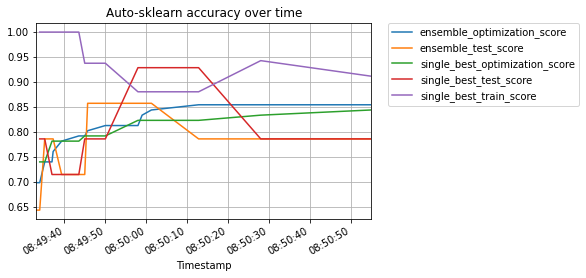

In [13]:
ensemble_performance_frame = pd.DataFrame(cls.automl_.ensemble_performance_history)
best_values = pd.Series({'ensemble_optimization_score': -np.inf,
                         'ensemble_test_score': -np.inf})
for idx in ensemble_performance_frame.index:
    if (
        ensemble_performance_frame.loc[idx, 'ensemble_optimization_score']
        > best_values['ensemble_optimization_score']
    ):
        best_values = ensemble_performance_frame.loc[idx]
    ensemble_performance_frame.loc[idx] = best_values

individual_performance_frame = get_runhistory_models_performance(cls)
best_values = pd.Series({'single_best_optimization_score': -np.inf,
                         'single_best_test_score': -np.inf,
                         'single_best_train_score': -np.inf})
for idx in individual_performance_frame.index:
    if (
        individual_performance_frame.loc[idx, 'single_best_optimization_score']
        > best_values['single_best_optimization_score']
    ):
        best_values = individual_performance_frame.loc[idx]
    individual_performance_frame.loc[idx] = best_values

pd.merge(
    ensemble_performance_frame,
    individual_performance_frame,
    on="Timestamp", how='outer'
).sort_values('Timestamp').fillna(method='ffill').plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('auto-sklearn_accuracy.png')
plt.show()